In [1]:
# from detection.custom_engine import train_model
from data_utils import get_augmented_reduced_datamodules, get_transform
from datasets import KittiTorch
from custom_engine import reset_environment, train_model, evaluate_model


reset_environment()

from configs import model_configs, epochs_list
from models import get_model

config = model_configs[0]


dataset = KittiTorch(root='../data', download=True, transform=get_transform())

train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = get_augmented_reduced_datamodules(dataset, batch_size=config['batch_size'])

datasets = (train_dataset, val_dataset, test_dataset)
dataloaders = (train_dataloader, val_dataloader, test_dataloader)

7481
7481


In [2]:
from models import get_fasterrcnn_mobilenet_v3_large_fpn

model = get_fasterrcnn_mobilenet_v3_large_fpn(11, pretrained=False, freeze_layers=False)


/opt/homebrew/Caskroom/miniforge/base/envs/cvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

/opt/homebrew/Caskroom/miniforge/base/envs/cvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


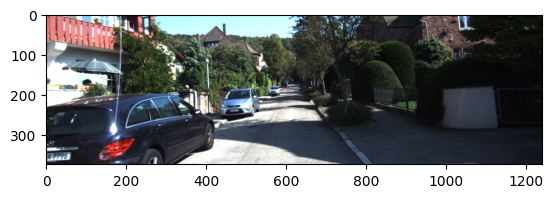

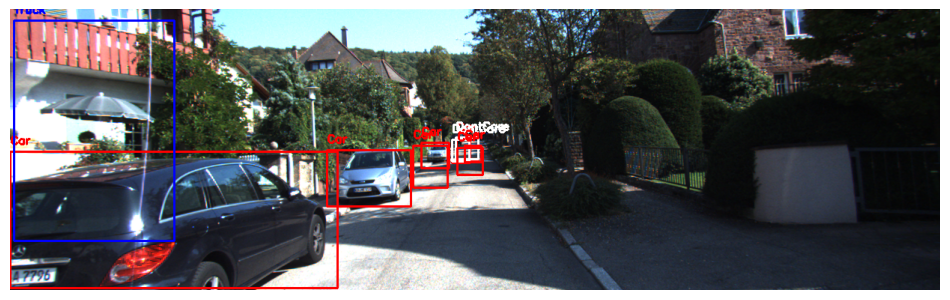

In [4]:
# Write the code that saves up the model from the internet and tests it
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np

#clear cache in cuda
torch.cuda.empty_cache()

image = test_dataset[80][0]
# Load the model
model = get_model(config)
model.load_state_dict(torch.load('../kitti_fasterrcnn_mobilenet_v3_large_320_fpn_5.pth', map_location='cpu'))

# # Ensure your model is on the GPU
model = model.to('cpu')

# Move the input tensor to the GPU
input_tensor = image.unsqueeze(0).to('cpu')


model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    predictions = model(input_tensor)


import cv2
import matplotlib.pyplot as plt
import numpy as np

# set seed 42
np.random.seed(42)

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    # Convert the image to CPU and NumPy format for plotting


    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.cpu().numpy().astype(int)
        label = int(label.cpu())
        box = box.astype(int)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

# Sample call to the function

target = predictions[0]
# image = dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)


In [5]:
print(evaluate_model(model, test_dataset, config['dataset_config']['class_list']))

Evaluation started...
Mean IoU: 0.1381
AP for Car: 0.5473
AP for Van: 0.3286
AP for Truck: 0.4022
AP for Pedestrian: 0.2758
AP for Person_sitting: 0.5942
AP for Cyclist: 0.1989
AP for Tram: 0.3390
AP for Misc: 0.2456
Mean Average Precision (mAP): 0.3665
Average Precision: 0.6501
Average Recall: 0.5526
Average F1-Score: 0.5944
(tensor(0.1381), 0.6501141760891369, 0.5526297137231707, 0.5943935400569964, 0.3664545768125219, {'Car_ap': 0.5472998736657926, 'Van_ap': 0.3286078555018741, 'Truck_ap': 0.40222621957490806, 'Pedestrian_ap': 0.2757743814457193, 'Person_sitting_ap': 0.5942015482691891, 'Cyclist_ap': 0.1988821922123478, 'Tram_ap': 0.33900794758369923, 'Misc_ap': 0.2456365962466452})
